## This notebook is for exploratory data analysis, cleaning and feature engineering for Task 4. Processed data will be saved as pickle files for modeling and quick recovery from unexpected system failure

## Task 4
* 4.1 Build a derived variable for tip as a percentage of the total fare.
* 4.2 Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). We will validate a sample.

Before jumping into any anlysis, it's helpful to use some intuition to think about what features can be used or engineered to predict the percentage of the total fare, here is a list that I came up with:

<table>
    <tr>
        <th>Feature Name</th>
        <th>Type</th>
        <th>Note</th>
    </tr>
    
    <tr>
        <td>vendor_id</td>
        <td>categorical</td>
        <td></td>
    </tr>
    
    <tr>
        <td>duration</td>
        <td>numerical, continuous</td>
        <td>dropoff time - pickup time</td>
    </tr>
    
    <tr>
        <td>pickup_hr</td>
        <td>categorical</td>
        <td>the hour of the day when pickup occurred. Value ranges from 0 to 23</td>
    </tr>
    
    <tr>
        <td>pickup_boro</td>
        <td>categorical</td>
        <td>which borough did the pickup occur. Value ranges from 1 to 5, 0 denotes none of the five areas.</td>
    </tr>
    
    <tr>
        <td>drop_boro</td>
        <td>categorical</td>
        <td>similar to pickup_boro</td>
    </tr>
    
    <tr>
        <td>rate_code</td>
        <td>categorical</td>
        <td></td>
    </tr>
    
    <tr>
        <td>trip_distance</td>
        <td>numerical, continuous</td>
        <td></td>
    </tr>
    
    <tr>
        <td>store_and_fwd_flag</td>
        <td>categorical</td>
        <td>true/false</td>
    </tr>
    
    <tr>
        <td>payment_type</td>
        <td>categorical</td>
        <td></td>
    </tr>
    
    <tr>
        <td>total_amount</td>
        <td>numerical, continuous</td>
        <td>fare_amount in the dataset represents payment calculated by distance while total_amount is the total payment incurred by a trip without tip. We will use total_amount instead of fare_amount because tip decisions are often made based upon total amount.</td>
    </tr>
    
    <tr>
        <td>passenger_count</td>
        <td>numerical, discrete</td>
        <td></td>
    </tr>
    
    <tr>
        <td>trip_type</td>
        <td>categorical</td>
        <td></td>
    </tr>
</table>

## magic shortcuts to subsections:

* [Explorary data analysis](#1)

* [Data cleaning & Fearture engineering](#2)

In [13]:
# load library
import pandas as pd # data analysis
pd.options.display.float_format = '{:,.3f}'.format
import seaborn as sns # visualization
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import geopandas as gpd # for processing geographical varibales
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point, Polygon, LineString
import pickle 

In [7]:
# load data
dataset = pd.read_csv('./data/green_tripdata_2015-09.csv')

<a id = 1> </a>
### Explorary data analysis
Before diving into more details, we will do some explorary data analysis to develop a better undertanding of the dataset:

* <b> missing values </b>

In [10]:
# print out the number of missing values associated with each feature
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494926 entries, 0 to 1494925
Data columns (total 21 columns):
VendorID                 1494926 non-null int64
lpep_pickup_datetime     1494926 non-null object
Lpep_dropoff_datetime    1494926 non-null object
Store_and_fwd_flag       1494926 non-null object
RateCodeID               1494926 non-null int64
Pickup_longitude         1494926 non-null float64
Pickup_latitude          1494926 non-null float64
Dropoff_longitude        1494926 non-null float64
Dropoff_latitude         1494926 non-null float64
Passenger_count          1494926 non-null int64
Trip_distance            1494926 non-null float64
Fare_amount              1494926 non-null float64
Extra                    1494926 non-null float64
MTA_tax                  1494926 non-null float64
Tip_amount               1494926 non-null float64
Tolls_amount             1494926 non-null float64
Ehail_fee                0 non-null float64
improvement_surcharge    1494926 non-null float64
To

Ehail_fee is completely missing, we will impute this feature. Other than this feature, Trip_type has only four missing values, we will ignore these cases.

In [11]:
# impute Ehail_fee because all of them are 'NA'
dataset.drop('Ehail_fee', axis = 1, inplace = True)

* <b> non-sense values </b>

To investigate non-sense values, we will first take a look at a summary statistics of all numerical values:

In [12]:
dataset.describe()

,VendorID,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,improvement_surcharge,Total_amount,Payment_type,Trip_type
count,"1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,926.00000","1,494,922.00000"
mean,1.78204,1.09765,-73.83084,40.69114,-73.83728,40.69291,1.37060,2.96814,12.54320,0.35128,0.48664,1.23573,0.12310,0.29210,15.03215,1.54056,1.02235
std,0.41286,0.63594,2.77608,1.53088,2.67791,1.47670,1.03943,3.07662,10.08278,0.36631,0.08504,2.43148,0.89101,0.05074,11.55316,0.52329,0.14783
min,1.00000,1.00000,-83.31908,0.00000,-83.42784,0.00000,0.00000,0.00000,-475.00000,-1.00000,-0.50000,-50.00000,-15.29000,-0.30000,-475.00000,1.00000,1.00000
25%,2.00000,1.00000,-73.95961,40.69895,-73.96782,40.69878,1.00000,1.10000,6.50000,0.00000,0.50000,0.00000,0.00000,0.30000,8.16000,1.00000,1.00000
50%,2.00000,1.00000,-73.94536,40.74674,-73.94504,40.74728,1.00000,1.98000,9.50000,0.50000,0.50000,0.00000,0.00000,0.30000,11.76000,2.00000,1.00000
75%,2.00000,1.00000,-73.91748,40.80255,-73.91013,40.79015,1.00000,3.74000,15.50000,0.50000,0.50000,2.00000,0.00000,0.30000,18.30000,2.00000,1.00000
max,2.00000,99.00000,0.00000,43.17726,0.00000,42.79934,9.00000,603.10000,580.50000,12.00000,0.50000,300.00000,95.75000,0.30000,581.30000,5.00000,2.00000


It's easy to spot some non-sense values from the table above. For example, Tip_amount, Tolls_amount, MTA_tax can't be negative. Trip_distnace can't be 0 mile. We will keep these observations in mind and impute these non-sense values later.

* <b> geographical locations </b>

Next, we will plot pickup and dropoff locations on NYC map to further investigate data quality. This analysis was inspired by this article: http://blog.yhat.com/posts/interactive-geospatial-analysis.html

In [15]:
# load NYC map, downloaded from 
# http://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/nybb/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=geojson
nyc_map = gpd.read_file('./data/query.txt')

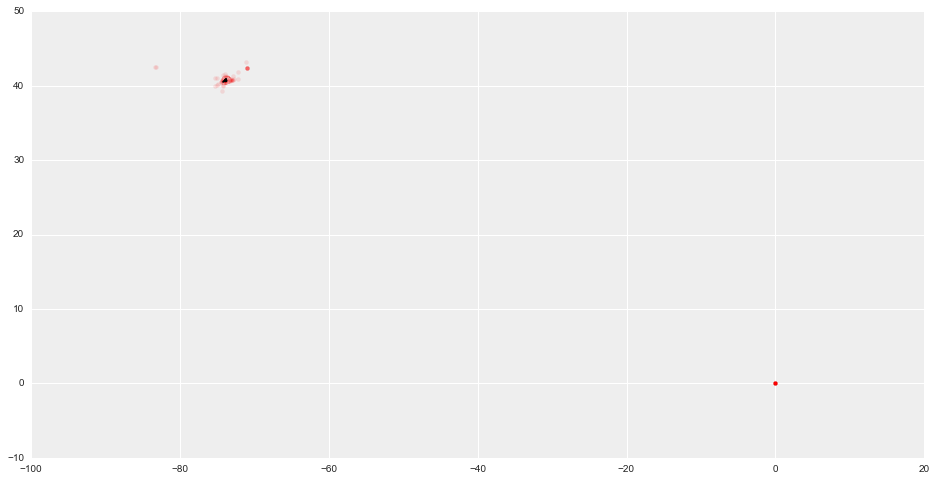

In [18]:
# visualize pick up locations
# we will plot each pick up location as a redish point on the map
plt.style.use('bmh')

# set figure size
plt.rcParams['figure.figsize'] = (16.0, 16.0)

fig, ax = plt.subplots()

ax.set_aspect('equal')

base = nyc_map.plot(ax = ax)

# plot locations on the map
plt.scatter(x=dataset['Pickup_longitude'], y=dataset['Pickup_latitude'], alpha=0.1, c='r')

The plot above shows that there exists pickup locations apparently outside of NYC. We will next show only locations with longitude from -73.6 to -74.3 and latitude from 40.4 to 41, which is at roughly the same area as NYC is.

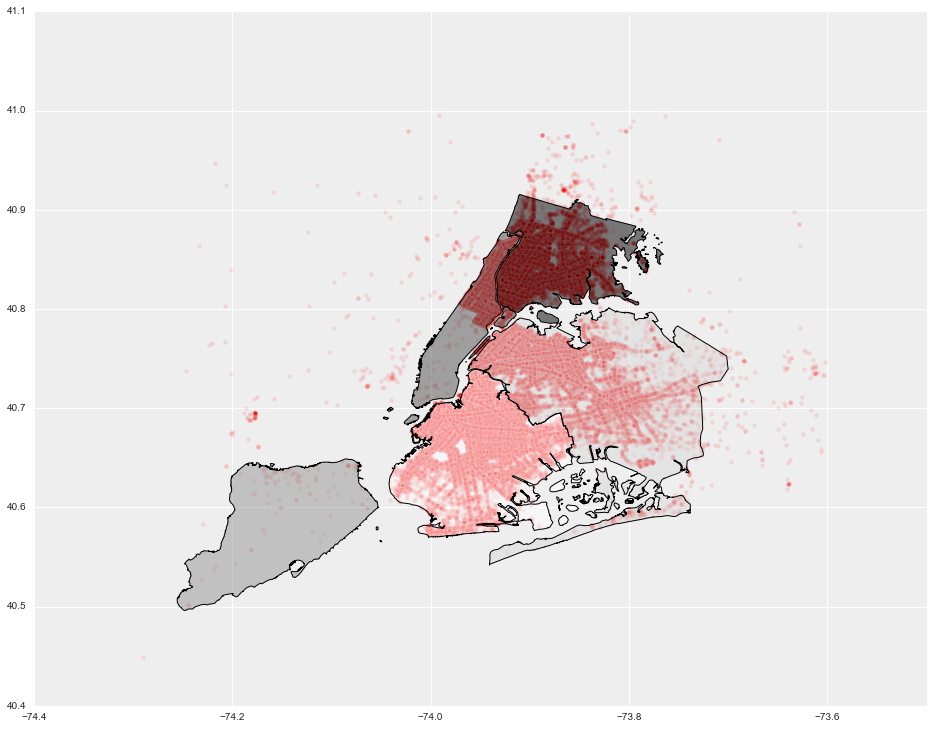

In [20]:
plt.style.use('bmh')

# set figure size
plt.rcParams['figure.figsize'] = (16.0, 16.0)

fig, ax = plt.subplots()

ax.set_aspect('equal')

base = nyc_map.plot(ax = ax)

# set filter criteria to only show points within NYC area
idx = ((dataset['Pickup_longitude'] > -74.3)  & (dataset['Pickup_longitude'] < -73.6) & 
(dataset['Pickup_latitude'] > 40.4) & (dataset['Pickup_latitude'] < 41))

# plot locations on the map
plt.scatter(x=dataset['Pickup_longitude'][idx], y=dataset['Pickup_latitude'][idx], alpha=0.1, c='r')

The pickup location data starts to make sense after applying this filtering criterion. The same situation applies to dropoff location data.

<a id = 2> </a>
### Data cleaning & Freature engineering

Create a new feature to represent the duration of each trip in minutes

In [23]:
# convert to datetime format
dataset['lpep_pickup_datetime'] = pd.to_datetime(dataset['lpep_pickup_datetime'])
dataset['Lpep_dropoff_datetime'] = pd.to_datetime(dataset['Lpep_dropoff_datetime'])

# calculate duration
duration = dataset['Lpep_dropoff_datetime'] - dataset['lpep_pickup_datetime']

# convert to minutes in numerical format
duration = pd.DatetimeIndex(duration)
duration = duration.hour * 60 + duration.minute 

Create a new feature to represent the hour of the day when the trip started

In [24]:
# convert to datetime format
pick_up_hr = pd.DatetimeIndex(dataset['lpep_pickup_datetime'])
# get hour of the day
pick_up_hr = pick_up_hr.hour

Create a new feature to represent the area of pickup and dropoff locations by mapping coordinates into the five borough areas in NYC

In [25]:
# Mapping each coordinate data to NYC boroughs is a computationally expensive job. 
# We'll therefore relax the NYC map into polygons to approximate the five boroughs.
nyc_hull = nyc_map['geometry'].convex_hull

In [27]:
# define a function that takes location coordinates as input and produce borough code as output
def whichBorough(point):
    '''
    return 1-5 if the point is mapped into NYC boroughs
    return 0 otherwise
    ---------
    args: 
        point, coordinate values, eg. (40.773460, -73.890349)
    ---------
    Five boroughs in NYC:
    1, Manhattan
    2, Bronx
    3, Brooklyn
    4, Queens
    5, Staten Island
        -- https://en.wikipedia.org/wiki/List_of_counties_in_New_York
    '''
    # conver data type
    point = Point(point)
    # determine which boro has been mapped into
    which_boro = nyc_hull.contains(point).values
    # if position can not be mapped into one of the five boros, reutrn 0
    if which_boro.sum() == 0:
        return 0
    # if position mapped to one of the five boros, return corresponding boro code
    else:
        return which_boro.argmax() + 1  

In [ ]:
# this is a computationally expensive job, we will save results for future reference
# pickup boros
pickup_boro = dataset[['Pickup_longitude', 'Pickup_latitude']].apply(lambda x: whichBorough(x), axis = 1)
# dropoff boros
dropoff_boro = dataset[['Dropoff_longitude', 'Dropoff_latitude']].apply(lambda x: whichBorough(x), axis = 1)

In [ ]:
## save pickup_boro and dropoff_boro for future reference
with open('./data/pickup_boro.p', 'wb') as handle:
    pickle.dump(pickup_boro, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/dropoff_boro.p', 'wb') as handle:
    pickle.dump(dropoff_boro, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
# next time, load from pickle
pickup_boro = pickle.load(open('./data/pickup_boro.p', 'rb' ))

dropoff_boro = pickle.load(open('./data/dropoff_boro.p', 'rb' ))

In [29]:
# compile features together
dataset2 = pd.DataFrame({'vendor_id': dataset['VendorID'], 'duration' : duration, 'pick_up_hr' : pick_up_hr,
                        'pickup_boro': pickup_boro, 'dropoff_boro': dropoff_boro, 'rate_code': dataset['RateCodeID'], 
                        'trip_distance': dataset['Trip_distance'], 'store_and_fwd_flag': dataset['Store_and_fwd_flag'],
                        'payment_type': dataset['Payment_type'], 'total_amount': dataset['Total_amount'], 'passenger_count': dataset['Passenger_count'],
                        'trip_type': dataset['Trip_type '], 'tip_amount': dataset['Tip_amount'],
                        'fare_amount': dataset['Fare_amount']})

data cleaning on features of 'durations', 'total_amount', 'trip_amount' and 'fare_amount' by excluding non-positive observations

In [65]:
dataset3 = dataset2[(dataset2['duration'] > 0) & (dataset2['total_amount'] > 0) &
                    (dataset2['trip_distance'] > 0) & (dataset2['fare_amount'] > 0)]

let's look at the distribution of 'durations', 'total_amount', 'trip_amount' and 'fare_amount' 

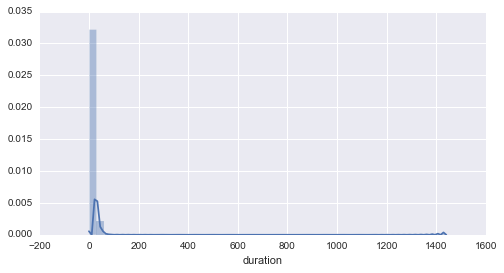

In [51]:
sns.set(rc={"figure.figsize": (8, 4)});
hist = sns.distplot(dataset3['duration'], axlabel = 'duration')
axes = hist.axes

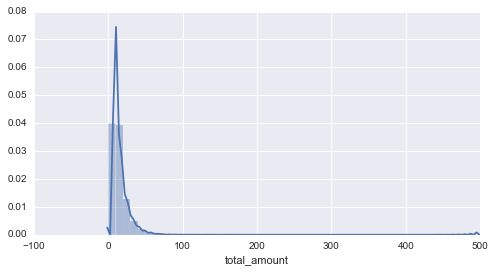

In [52]:
sns.set(rc={"figure.figsize": (8, 4)});
hist = sns.distplot(dataset3['total_amount'], axlabel = 'total_amount')
axes = hist.axes

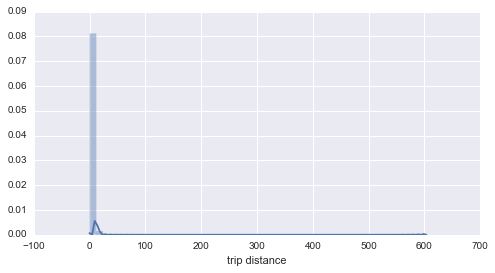

In [53]:
sns.set(rc={"figure.figsize": (8, 4)});
hist = sns.distplot(dataset3['trip_distance'], axlabel = 'trip distance')
axes = hist.axes

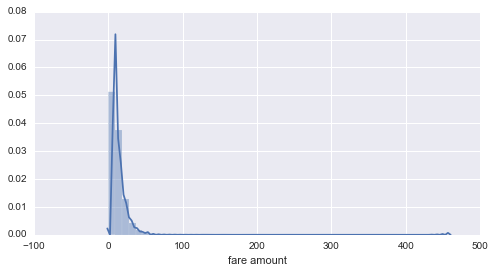

In [54]:
sns.set(rc={"figure.figsize": (8, 4)});
hist = sns.distplot(dataset3['fare_amount'], axlabel = 'fare amount')
axes = hist.axes

all of the four features are long-tailed distributed, we will further clean them up

In [91]:
dataset3 = dataset3[dataset3['duration'] < 90]
dataset3 = dataset3[dataset3['total_amount'] < 100]
dataset3 = dataset3[dataset3['trip_distance'] < 100]
dataset3 = dataset3[dataset3['fare_amount'] < 100]

distribution plot after data cleaning makes more sense:

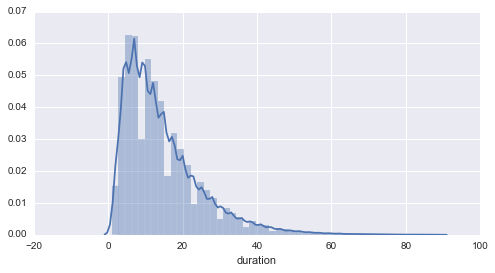

In [92]:
sns.set(rc={"figure.figsize": (8, 4)});
hist = sns.distplot(dataset3['duration'], axlabel = 'duration')
axes = hist.axes

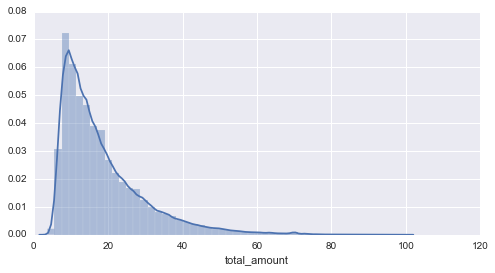

In [93]:
sns.set(rc={"figure.figsize": (8, 4)});
hist = sns.distplot(dataset3['total_amount'], axlabel = 'total_amount')
axes = hist.axes

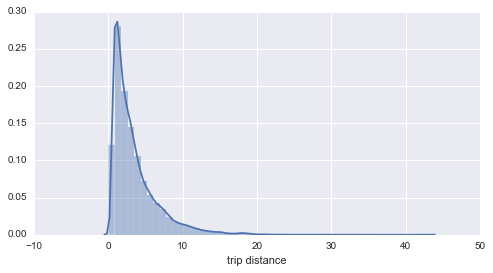

In [94]:
sns.set(rc={"figure.figsize": (8, 4)});
hist = sns.distplot(dataset3['trip_distance'], axlabel = 'trip distance')
axes = hist.axes

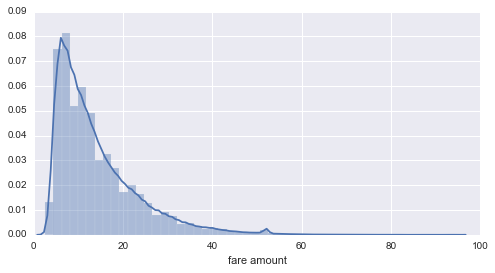

In [95]:
sns.set(rc={"figure.figsize": (8, 4)});
hist = sns.distplot(dataset3['fare_amount'], axlabel = 'fare amount')
axes = hist.axes

data clearning to exclude trip that happened outside NYC

In [96]:
# remove trip with neither start and end point outside of the five boroughs in NYC
dataset3 = dataset3[(dataset3['pickup_boro'] != 0) | (dataset3['dropoff_boro'] != 0)]

Create a new feature to represent the average speed miles/hr

In [97]:
# average speed, miles/hr
dataset3['avg_speed'] = dataset3['trip_distance'] / (dataset3['duration'] / 60)

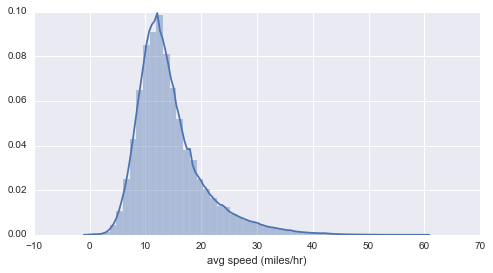

In [98]:
sns.set(rc={"figure.figsize": (8, 4)});
hist = sns.distplot(dataset3['avg_speed'], axlabel = 'avg speed (miles/hr)')
axes = hist.axes

data cleaning to exclude observations with non-sense speed (> 60 miles/hr)

In [76]:
dataset3 = dataset3[dataset3['avg_speed'] < 60]

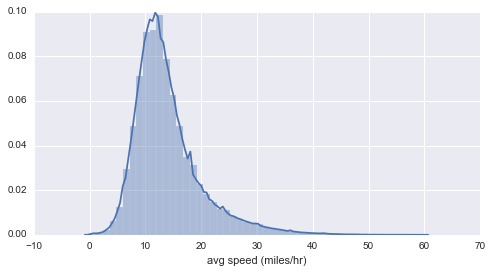

In [78]:
# distribution plot afterwards
sns.set(rc={"figure.figsize": (8, 4)});
hist = sns.distplot(dataset3['avg_speed'], axlabel = 'avg speed (miles/hr)')
axes = hist.axes

calculate the percentage of tips in terms of the total fare

In [79]:
dataset3['tip_percent'] = dataset3['tip_amount'] / dataset3['fare_amount']

let's get some summary statistics first:

In [81]:
dataset3['tip_percent'].describe()

count   1,447,018.000
mean            0.093
std             0.178
min             0.000
25%             0.000
50%             0.000
75%             0.214
max            99.000
Name: tip_percent, dtype: float64

It seems over half of transactions didn't have a tip at all. The maximum percentage is 99%, which doesn't make sense. We will only include trips with tip percentage greater than 0% and less than 50% in our modeling

In [82]:
dataset3 = dataset3[(dataset3['tip_percent'] > 0) & (dataset3['tip_percent'] < .50)]

distribution plot after further cleaning

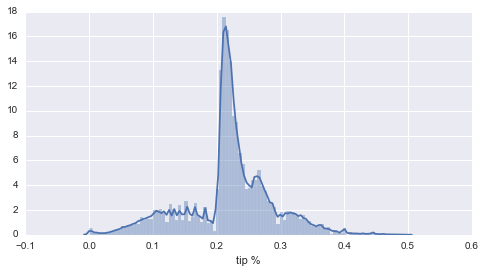

In [83]:
sns.set(rc={"figure.figsize": (8, 4)});
hist = sns.distplot(dataset3['tip_percent'], axlabel = 'tip %', bins = 100)
axes = hist.axes

Up to now, the data is almost ready to use. We will further apply several transformations:

* One-hot encoding on categorical features:

In [84]:
# transform string-valued feature to integer-valued feature
dataset3['store_and_fwd_flag'].replace(['N', 'Y'], [0, 1], inplace = True)

# categorical feature list
cat_cols = ['pickup_boro', 'dropoff_boro', 'payment_type', 
            'store_and_fwd_flag', 'trip_type', 'pick_up_hr', 
            'vendor_id', 'rate_code', 'passenger_count']

# import one-hot encoding package
from sklearn import preprocessing

# apply one-hot endoing and transform into sparse matrix
OHE = preprocessing.OneHotEncoder(sparse=True)
dataset3_ohe = OHE.fit_transform(dataset3[cat_cols])

In [85]:
# numerical values that will be included in the modeling
num_cols = ['duration', 'fare_amount', 'total_amount', 'trip_distance', 'avg_speed']

In [86]:
# put both numerical and categorical features together
from scipy import sparse
x = sparse.hstack((dataset3_ohe, dataset3[num_cols]), format='csr')

In [87]:
# tip percentage
y = dataset3['tip_percent'] * 100

split into training and testing dataset with 80% / 20% rule

In [88]:
np.random.seed(20170429)
train_idx = np.random.choice(x.shape[0], int(x.shape[0] * .8), replace=False)
test_idx = np.ones(x.shape[0], np.bool)
test_idx[train_idx] = False

In [89]:
train_x = x[train_idx]
train_y = y.as_matrix()[train_idx]

test_x = x[test_idx]
test_y = y.as_matrix()[test_idx]

save processed data for modeling and future reference

In [90]:
with open('./data/train_x.p', 'wb') as handle:
    pickle.dump(train_x, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./data/train_y.p', 'wb') as handle:
    pickle.dump(train_y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/test_x.p', 'wb') as handle:
    pickle.dump(test_x, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./data/test_y.p', 'wb') as handle:
    pickle.dump(test_y, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Now, our data is ready to be used for modeling :-)